# THESIS - a Simple Model   

# Imports 

In [1]:
#imports

from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import shlex, subprocess
import os , sys

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

2023-02-01 15:01:53.080259: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 1. Preparation of the dataset 
- One hot encoding the sequences 

In [29]:

#One-hot encoding 

#for every fasta sequence, encode and maybe add to a list (?) --> now trying to add everything to an array --> eventually in a matrix
def onehotencode(seq) : 
    values = list(seq)
    values = np.array(values)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    #print(label_encoder.classes_)
    #print(integer_encoded)
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    #print(onehot_encoder.categories_)
    #print(np.shape(onehot_encoded))
    return onehot_encoded

In [30]:
#preparation of the test dataset 
from Bio import SeqIO

fasta_sequences = SeqIO.parse(open('data.fasta'),'fasta')
seq_array = np.zeros((1,150,4)) #this first array should be removed ? is it a probelm for it to be there ?
labels = array([[]])
for fasta in fasta_sequences:
    name, sequence = fasta.id, str(fasta.seq)
    #print (name)
    
    new_sequence = onehotencode(sequence)
    #print(np.shape(new_sequence))
    if np.shape(new_sequence) == (150,4): #apparently some of the sequences have a different shape, for the aim of testing I won't investigate 
        labels = np.append(labels,int(name))
        new_sequence = np.expand_dims(new_sequence, axis =0)
        #print(np.shape(new_sequence))
        #print(new_sequence)
        seq_array = np.vstack((seq_array,new_sequence))
        #seq_array = np.concatenate((seq_array, new_sequence))#just concatenating all of the sequences --> actually just 36 sequences, why?--> because of hg19, now it's fine, all of them have been added  
        #break #to be removed after testing
    
seq_array = np.delete(seq_array, 0, 0) #to remove the first array of zeros 

/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib

In [31]:
print(np.shape(seq_array))
np.shape(labels)

(19368, 150, 4)


(19368,)

In [53]:
type(labels[0])

numpy.float64

In [ ]:
#preparation of the encoded dataset 
from Bio import SeqIO

fasta_sequences = SeqIO.parse(open('processed/AARS_K562/peaks.crosslink.anno.filt.slop.fa.out'),'fasta')
seq_array = np.zeros((1,401,4)) #this first array should be removed ? is it a probelm for it to be there ?
for fasta in fasta_sequences:
    name, sequence = fasta.id, str(fasta.seq)
    #print (name)
    new_sequence = onehotencode(sequence)
    #print(np.shape(new_sequence))
    new_sequence = np.expand_dims(new_sequence, axis =0)
    #print(np.shape(new_sequence))
    #print(new_sequence)
    seq_array = np.vstack((seq_array,new_sequence))
    #seq_array = np.concatenate((seq_array, new_sequence))#just concatenating all of the sequences --> actually just 36 sequences, why?--> because of hg19, now it's fine, all of them have been added  
    #break #to be removed after testing
seq_array = np.delete(seq_array, 0, 0) #to remove the first array of zeros 

In [19]:
np.shape(seq_array)
#seq_array
    

(19369, 150, 4)

- Preparation of the labels 

In [5]:
#preparation of the labels for the positive and negative dataset 
labels_positive = np.ones((np.shape(seq_array)[0], 1))
print( labels_positive) 

[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


- Splitting of the dataset : test, train and validation sets 

In [70]:
#validation-test split 
import numpy as np
from sklearn.model_selection import train_test_split

X = seq_array
#y = labels_positive
y = labels

#parameters 
test_size1 = 0.33
test_size2 = 0.15

#test set

X, x_test, y, y_test = train_test_split(X, y, test_size=test_size1, shuffle=False) #--> shuffle should be false logically (?)

#validation set 

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=test_size2, shuffle=False)



In [71]:
# Prepare the training dataset.
#parameters
batch_size = 41 #--> how much should be my batch size? 

# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.batch(batch_size)#.shuffle(buffer_size=1024).batch(batch_size) # --> does it make sense to shuffle ? 

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(batch_size)

In [72]:
np.shape(train_dataset)

()

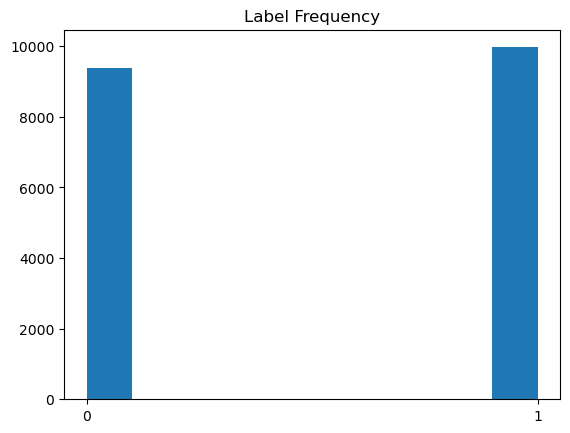

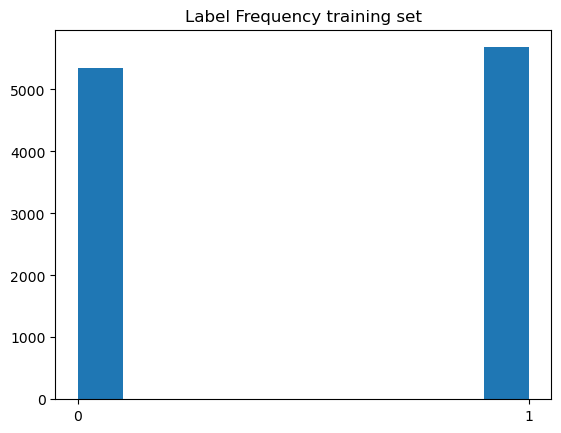

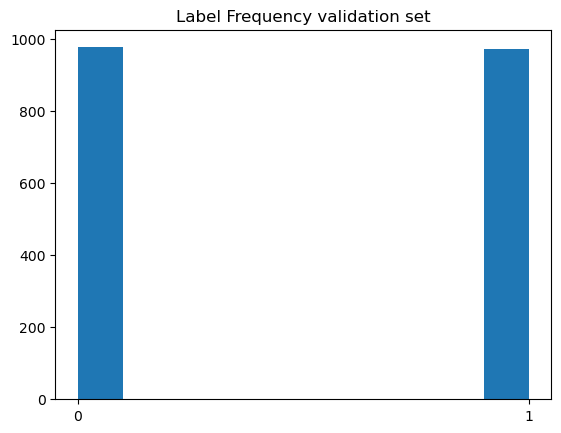

In [73]:
#checking class ditribution in the whole dataset and training set
import matplotlib.pyplot as plt

plt.hist(labels)
plt.xticks(range(2))
plt.title('Label Frequency')
plt.show()

plt.hist(y_train)
plt.xticks(range(2))
plt.title('Label Frequency training set')
plt.show()

plt.hist(y_val)
plt.xticks(range(2))
plt.title('Label Frequency validation set')
plt.show()

# 2. Model  
- Instantiate an optimizer 

In [74]:
# Instantiate an optimizer.

#optimizer = keras.optimizers.SGD(learning_rate=1e-3)#or adam ? --> check  
optimizer = keras.optimizers.Adam(learning_rate=1e-3)


# Instantiate a loss function.
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)#parameter is recommended


# 2.1 .compile() 
- Create the baseline model 

In [79]:
#first is .compile() --> to create the baseline model : no dataset
def create_baseline():
   
    #the first layer should be a convolutional layer
    #conv-maxpooling-dropout-conv-maxpooling-dropout-flatten-(dense-dropout)-dense --> this is the pysster architecture 
    #how long should the kernel be? 
    #the parameters are now the default ones from pysster
    
    #parameters 
    input_shape = (150, 4)
    batch_size = 41
    filters = 30
    kernel_size = 25
    pool_size = 2
    strides = 2
    #activation ? 
    #kernel_initializer ? 
    loss='binary_crossentropy'
    optimizer='adam' 
    metrics=['accuracy']
    
    # create model
        
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape= input_shape, batch_size=batch_size, ))
    model.add(keras.layers.Conv1D(filters=filters,kernel_size=kernel_size,#kernel_size is kernel length right? 
              kernel_initializer=tf.keras.initializers.constant(1), #to be changed once I have the actual input data
             #glorot_uniform(seed=12)
              activation='relu',input_shape=input_shape[1:])) #--> idk what to add
             #or without data? )
    model.add(keras.layers.MaxPooling1D(pool_size=pool_size, strides=strides, padding='valid'))#valid or same? padding or not 
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Conv1D(filters=filters,kernel_size=kernel_size,
              kernel_initializer=tf.keras.initializers.constant(1), 
             #glorot_uniform(seed=12)
              activation='relu',input_shape=input_shape[1:] ))#--> idk what to add

    model.add(keras.layers.MaxPooling1D(pool_size=pool_size, strides=strides, padding='valid'))
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Flatten())#without parameters

    #model.add(keras.layers.Dense(4, activation='relu'))#is it always relu? also sigmoid is an option 
    #model.add(keras.layers.Dropout(0.6))

    model.add(keras.layers.Dense(1, activation='sigmoid'))#what should be the output shape? 1? 

    
    # Compile model
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # for binary classification
    
    model.compile( optimizer=keras.optimizers.Adam(learning_rate=1e-3),# Optimizer
                    # Loss function to minimize
                    loss=keras.losses.BinaryCrossentropy(),
                    # List of metrics to monitor
                    metrics=[keras.metrics.BinaryAccuracy()],)
        #model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # for multi class
    return model


In [80]:

#input_shape = (3388, 401, 4) 
model = create_baseline()

In [81]:
print(model.layers)

print(model.summary()) 

[<keras.layers.convolutional.conv1d.Conv1D object at 0x7fd3e3f178b0>, <keras.layers.pooling.max_pooling1d.MaxPooling1D object at 0x7fd3e3f17b80>, <keras.layers.regularization.dropout.Dropout object at 0x7fd3e3f17130>, <keras.layers.convolutional.conv1d.Conv1D object at 0x7fd3e3f14940>, <keras.layers.pooling.max_pooling1d.MaxPooling1D object at 0x7fd3e3f14520>, <keras.layers.regularization.dropout.Dropout object at 0x7fd3e825e950>, <keras.layers.reshaping.flatten.Flatten object at 0x7fd3e9650250>, <keras.layers.core.dense.Dense object at 0x7fd3e3f156f0>]
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (41, 126, 30)             3030      
                                                                 
 max_pooling1d_16 (MaxPoolin  (41, 63, 30)             0         
 g1D)                                                            
                      

# 2.2 .fit() 
- Training the model 

In [82]:
#second is to use .fit() --> to train the model : use x_train, y_train --> either .fit() or training loop from scratch (see below)
print("Fit model on training data")

#parameters 
batch_size=41
epochs= 20

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val),
)

Fit model on training data
(11029, 150, 4)
(11029,)
Epoch 1/20
261/269 [============================>.] - ETA: 0s - loss: 5668.0649 - binary_accuracy: 0.4944

InvalidArgumentError: Graph execution error:

Detected at node 'binary_crossentropy/logistic_loss/GreaterEqual' defined at (most recent call last):
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/asyncio/base_events.py", line 1899, in _run_once
      handle._run()
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2945, in run_cell
      result = self._run_cell(
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3000, in _run_cell
      return runner(coro)
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3203, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3382, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3442, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_183383/3164870190.py", line 11, in <module>
      history = model.fit(
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/keras/engine/training.py", line 1694, in fit
      val_logs = self.evaluate(
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/keras/engine/training.py", line 2040, in evaluate
      tmp_logs = self.test_function(iterator)
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/keras/engine/training.py", line 1820, in test_function
      return step_function(self, iterator)
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/keras/engine/training.py", line 1804, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/keras/engine/training.py", line 1792, in run_step
      outputs = model.test_step(data)
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/keras/engine/training.py", line 1758, in test_step
      self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/keras/engine/training.py", line 1082, in compute_loss
      return self.compiled_loss(
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/keras/losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/keras/losses.py", line 284, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/keras/losses.py", line 2176, in binary_crossentropy
      backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/keras/backend.py", line 5680, in binary_crossentropy
      return tf.nn.sigmoid_cross_entropy_with_logits(
Node: 'binary_crossentropy/logistic_loss/GreaterEqual'
Incompatible shapes: [20,1] vs. [41,1]
	 [[{{node binary_crossentropy/logistic_loss/GreaterEqual}}]] [Op:__inference_test_function_20508]

In [13]:
history.history

NameError: name 'history' is not defined

In [91]:
#first attempt of a training loop from scratch --> added the evaluation loop here 

#parameters
#input_shape = (3388, 401, 4)
input_shape = (150, 4)
epochs = 5 #for the test 
#optimizer = keras.optimizers.SGD(learning_rate=1e-3)#or adam ? --> check  
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)#parameter is recommended
# Prepare the metrics.
train_acc_metric = keras.metrics.BinaryAccuracy()
val_acc_metric = keras.metrics.BinaryAccuracy()


model = create_baseline()

import time

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()
    
    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset): #172 steps
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = model(x_batch_train, training=True)  
            #print("Number of weights after calling the model:", len(model.weights))

            # Compute the loss value for this minibatch.
            loss_value = loss_fn(y_batch_train, logits)
            
        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights)) #I think it doesn't work because there's just one class now . 

        # Log every 200 batches.
        if (step % 50) == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * batch_size))
    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        val_logits = model(x_batch_val, training=False)
        # Update val metrics
        val_acc_metric.update_state(y_batch_val, val_logits)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Time taken: %.2fs" % (time.time() - start_time))
    


Start of epoch 0
Training loss (for one batch) at step 0: 0.7453
Seen so far: 64 samples
Training loss (for one batch) at step 50: 0.8758
Seen so far: 3264 samples
Training loss (for one batch) at step 100: 0.8758
Seen so far: 6464 samples
Training loss (for one batch) at step 150: 0.9226
Seen so far: 9664 samples
Training acc over epoch: 0.0000
Validation acc: 0.4987
Time taken: 8.33s

Start of epoch 1
Training loss (for one batch) at step 0: 0.7351
Seen so far: 64 samples
Training loss (for one batch) at step 50: 0.8817
Seen so far: 3264 samples
Training loss (for one batch) at step 100: 0.8758
Seen so far: 6464 samples
Training loss (for one batch) at step 150: 0.9226
Seen so far: 9664 samples
Training acc over epoch: 0.0000
Validation acc: 0.4987
Time taken: 4.04s

Start of epoch 2
Training loss (for one batch) at step 0: 0.7351
Seen so far: 64 samples
Training loss (for one batch) at step 50: 0.8758
Seen so far: 3264 samples
Training loss (for one batch) at step 100: 0.8758
Seen 

# 2.3 .evaluate() 
- Get loss value and metrics values

In [73]:
#3rd is to use .evaluate() --> get loss value and metrics values : use x_val, y_val
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
#parameters
batch_size = 64
results = model.evaluate(x_test, y_test, batch_size=batch_size)
print("test loss, test acc:", results)

Evaluate on test data
 93/100 [==========================>...] - ETA: 0s - loss: 24934.4883 - accuracy: 0.5186

InvalidArgumentError: Graph execution error:

Detected at node 'binary_crossentropy/logistic_loss/GreaterEqual' defined at (most recent call last):
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/asyncio/base_events.py", line 1899, in _run_once
      handle._run()
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2945, in run_cell
      result = self._run_cell(
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3000, in _run_cell
      return runner(coro)
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3203, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3382, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3442, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_178908/2710481467.py", line 6, in <module>
      results = model.evaluate(x_test, y_test, batch_size=batch_size)
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/keras/engine/training.py", line 2040, in evaluate
      tmp_logs = self.test_function(iterator)
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/keras/engine/training.py", line 1820, in test_function
      return step_function(self, iterator)
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/keras/engine/training.py", line 1804, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/keras/engine/training.py", line 1792, in run_step
      outputs = model.test_step(data)
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/keras/engine/training.py", line 1758, in test_step
      self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/keras/engine/training.py", line 1082, in compute_loss
      return self.compiled_loss(
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/keras/losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/keras/losses.py", line 284, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/keras/losses.py", line 2176, in binary_crossentropy
      backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/keras/backend.py", line 5680, in binary_crossentropy
      return tf.nn.sigmoid_cross_entropy_with_logits(
Node: 'binary_crossentropy/logistic_loss/GreaterEqual'
Incompatible shapes: [56,1] vs. [64,1]
	 [[{{node binary_crossentropy/logistic_loss/GreaterEqual}}]] [Op:__inference_test_function_9275829]

In [86]:
#training and evaluation loop --> first attempt to merge training and evaluation loop 

#parameters
input_shape = (150, 4) 
epochs = 5
batch_size = 64

# Prepare the metrics.
train_acc_metric = keras.metrics.BinaryAccuracy()
val_acc_metric = keras.metrics.BinaryAccuracy()

#model = create_baseline()

import time


for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)
            loss_value = loss_fn(y_batch_train, logits)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Update training metric.
        train_acc_metric.update_state(y_batch_train, logits)

        # Log every 200 batches.
        if step % 50 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %d samples" % ((step + 1) * batch_size))

    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        val_logits = model(x_batch_val, training=False)
        # Update val metrics
        val_acc_metric.update_state(y_batch_val, val_logits)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Time taken: %.2fs" % (time.time() - start_time))


Start of epoch 0
Training loss (for one batch) at step 0: 0.6931
Seen so far: 64 samples
Training loss (for one batch) at step 50: 0.6931
Seen so far: 3264 samples
Training loss (for one batch) at step 100: 0.6931
Seen so far: 6464 samples
Training loss (for one batch) at step 150: 0.6931
Seen so far: 9664 samples
Training acc over epoch: 0.4849
Validation acc: 0.5013
Time taken: 4.65s

Start of epoch 1
Training loss (for one batch) at step 0: 0.6931
Seen so far: 64 samples
Training loss (for one batch) at step 50: 0.6931
Seen so far: 3264 samples
Training loss (for one batch) at step 100: 0.6931
Seen so far: 6464 samples
Training loss (for one batch) at step 150: 0.6931
Seen so far: 9664 samples
Training acc over epoch: 0.4850
Validation acc: 0.5013
Time taken: 4.28s

Start of epoch 2
Training loss (for one batch) at step 0: 0.6931
Seen so far: 64 samples
Training loss (for one batch) at step 50: 0.6931
Seen so far: 3264 samples
Training loss (for one batch) at step 100: 0.6931
Seen 

# 2.4 .predict() 
- Get output predictions

In [ ]:
#4th is to use .predict() --> to get predictions as output : use x_test, y_test
# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(x_test[:3])
print("predictions shape:", predictions.shape)

In [ ]:
model.compile(loss='binary_crossentropy',
optimizer=RMSprop(lr=0.001), 
metrics='accuracy')

In [ ]:
history = model.fit(train_generator,
steps_per_epoch=8,
epochs=15,
verbose=1,
validation_data = validation_generator,
validation_steps=8)

In [49]:

from Bio import SeqIO
for sequence in SeqIO.parse('processed/AARS_K562/peaks.crosslink.anno.filt.slop.fa.out', "fasta"):
    print(sequence.id)
    print(sequence.seq)
    print(len(sequence))

chr15:96282738-96283139
AAGAATGTCCCAAGTGGGTGCTATTAGGAGACTAAAGGCCCAAATCAAGATTAAAAGTAATTTCAGCAATGATGGAATATAGTAAATGCTTACCAAAGAAAGGTTAGCAGCTGAACCGCAAACCCCACCTGACAGCCCTTGGATTGGAGCAAGCTTCATCATGAAGATCTCAAAGCTGTATCTGGTGGAGATGCCGGGCATTGTGGCACCAGGGCCCACTGTCCCATGACACTGTGCTGGACAACTGGCTCCTGGGATAAGACAAGTCAGAGCAGAGAAGGGCGTGAGTCACGTGGAATATAAGATAGGATTTGAGGAGGCAAGAGACAGTGGCCATAAAGAAGGAAAACAAGATGAATATGTATATTGCAAGCAGTTGACTGAGGAATGAGACAAGGGCA
401
chr15:96282721-96283122
AAAACAAAACAGAAACAAAGAATGTCCCAAGTGGGTGCTATTAGGAGACTAAAGGCCCAAATCAAGATTAAAAGTAATTTCAGCAATGATGGAATATAGTAAATGCTTACCAAAGAAAGGTTAGCAGCTGAACCGCAAACCCCACCTGACAGCCCTTGGATTGGAGCAAGCTTCATCATGAAGATCTCAAAGCTGTATCTGGTGGAGATGCCGGGCATTGTGGCACCAGGGCCCACTGTCCCATGACACTGTGCTGGACAACTGGCTCCTGGGATAAGACAAGTCAGAGCAGAGAAGGGCGTGAGTCACGTGGAATATAAGATAGGATTTGAGGAGGCAAGAGACAGTGGCCATAAAGAAGGAAAACAAGATGAATATGTATATTGCAAGCAGTTGACTGA
401
chr15:96282726-96283127
AAAACAGAAACAAAGAATGTCCCAAGTGGGTGCTATTAGGAGACTAAAGGCCCAAATCAAGATTAAAAGTAATTTCAGCAATGATGGAATATAGTAAATGCTTACCAAAGAAAGGT

In [11]:
#interesting library for visualization --> I don't know how to save 
import squiggle 
print(subprocess.run(f"squiggle 'processed/AARS_K562/peaks.crosslink.anno.filt.slop.fa.out' --method=gates -o processed/AARS_K562/image2.html", shell = True))

CompletedProcess(args="squiggle 'processed/AARS_K562/peaks.crosslink.anno.filt.slop.fa.out' --method=gates -o processed/AARS_K562/image2.html", returncode=1)


Traceback (most recent call last):
  File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/bin/squiggle", line 8, in <module>
    sys.exit(visualize())
  File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/click/core.py", line 1130, in __call__
    return self.main(*args, **kwargs)
  File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/click/core.py", line 1055, in main
    rv = self.invoke(ctx)
  File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/click/core.py", line 1404, in invoke
    return ctx.invoke(self.callback, **ctx.params)
  File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/click/core.py", line 760, in invoke
    return __callback(*args, **kwargs)
  File "/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/squiggle/cli.py", line 49, in visualize
    if len([record for _f in fasta for r